In [110]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('max_colwidth', None)
# Load data using Python JSON module
with open('filter_all_t.json','r') as f:
    data = json.loads(f.read())


In [111]:

# Flatten data
df_tr = pd.json_normalize(data, record_path =['train'])
#df_ts = pd.json_normalize(data, record_path =['test'])

#df=pd.concat([df_tr,df_ts])

import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
  
stop_words = set(stopwords.words('english'))
    
for i, r in enumerate(df_tr['review_text']):
    word_tokens = word_tokenize(r)
    filtered_review=''
    for w in word_tokens:
        if w.lower() not in stop_words:
            filtered_review = filtered_review+w+" "
    df_tr.at[i, 'review_text_filtered'] = filtered_review 



# Create a single dataframe having user id, restaurant id and the reviews received for each separately

df1=pd.DataFrame()
df1[['id','review_text_filtered']]=df_tr[['business_id','review_text_filtered']]
df1['type']='B'

df2=pd.DataFrame()
df2[['id','review_text_filtered']]=df_tr[['user_id','review_text_filtered']]
df2['type']='U'

df = pd.concat([df1, df2],ignore_index=True)

df

,id,review_text_filtered,type
0,60567465d335d0abfb415b26,"tang tomato sauce outstanding . crust meal , . Order whole pie fresh .",B
1,6050fa9f5b4ccec8d5cae994,Chicken waffles really good !,B
2,604be10877e81aaed3cc9a1e,"appetizer colossal shrimp good freshwater Lobster bit disappointing . lobster mac cheese great . got 40 day dry aged rib steak two . cooked well , wish signature aged steak flavor .",B
3,60411e017cd8bf130362365a,fish tacos omg ! salad great also .,B
4,604139dd7cd8bf1303624208,"Ribs great , mac cheese , fries onion rings . Skip brisket blueberry cornbread .",B
...,...,...,...
174021,116424268004501507050,tacos okay .,U
174022,117588849143422747708,Pasta Mardi Gras,U
174023,105232116717227512438,"order Pork Bar-B-Que pizza ( favorite ) another pizza never tried . Last night , tried Everything Pizza . crust pizzas thin perfect crisp crunch . $ 17 10 inch pizza little expensive , enjoy Bar-B-Que pizza pay . Pete Sams pizzas never disappoint , try !",U
174024,111963502676898067823,"Beer tasty , Alt one favorites .",U


In [112]:
# Concatenate reviews for each user id and restaurant id respectively. Thus we have a final 'data' dataframe that has all 
# reviews any user has ever written and all reviews any restaurant has ever received

data = df.groupby(['id','type'])['review_text_filtered'].apply(lambda x: ' '.join(x)).reset_index()
data

,id,type,review_text_filtered
0,100000106576186066497,U,tasty chicken waffles brunch dumplings noodle crepe ca n't beat . quesabirria tacos super .
1,100000149611993816967,U,"Great service Carnita nachos tres leches great ok tnt roll great 20 bucks roll idk offer 12-13 roll home run . scallops , tuna , Chilean sea bass , sexy shrimp excellent ."
2,100000712665450694665,U,"Tortillas everyone ! selection 10 different English muffins chocolate chip cherry . corn beef hash homemade coffee perfect . Starting front line , slice meat right front plate 're sides desserts . Enjoy soft serve vanilla cone cup hand end meal . salad fruit potato soup . 3 different types meat platter sammie . fries wedge potato salad like home . Tiramisu delish even 1 bite let fast metabolism husband pig rest . made pasta divine ."
3,100000916384489212081,U,"Prompt friendly service , food arrived quickly , burger shake ( vanilla malt ) delicious . Delicious burger reasonable price , fast friendly service ."
4,100001187787951615454,U,"burger warm delicious fries cold nasty . Tiger Roll go , let tried baked scallop roll right kick burst freshness cilantro topping ! BBQ mix plate chicken mix plate gyoza side . Everything super delicious tasted fresh ."
...,...,...,...
57487,60572c39c4674474cff912d9,B,"choose additional toppings like assorted veggies , proteins , sauces , anything extra . gave us good recommendations ordered spicy chicken protein udon noodles additional toppings . delicious 're looking something good , try udon noodles spicy chicken ! 've heard bulgogi good ."
57488,60572c51f69c7b1178070363,B,"enjoyed charcoaled sampler two $ 37 ( pork kabob , chicken kabob , marinated chicken breast , two rack lamb chops , homemade sausage gyro meat ) perfect thing share try little everything ."
57489,60572d22c4674474cff912db,B,"Korean food great ! got Bilgogi , wife got spicy chicken Bilgogi got rice cakes appetizer . Authentic , delicious , large portions Korean food . ordered jjangbong , spicy seafood noodle soup . didnt skimp seafood put noodle soup ."
57490,60572d91d2ad6b7a67e27fdf,B,"Delicious cakes deli . Cake slices huge best sharing . one line bakery deli , read signs order 'd end waiting told stand line . combination corned beef pastrami sandwich coleslaw pickle Marble rye . meat basically melted mouth . bakery looked amazing sandwich big n't room dessert . Lox way go ! ordered omelets , good hoped extras would mixed omelet sitting top eggs . Bagel good , Einstein 's flavor ."


In [113]:
# Master database on user-restaurant-rating grain

d1=pd.merge(df_tr[['user_id','business_id','rating','review_text_filtered']],data[['review_text_filtered','id']],left_on='user_id',right_on='id')
d1.rename(columns = {'review_text_filtered_x':'review'}, inplace = True)
d1.rename(columns = {'review_text_filtered_y':'user_reviews'}, inplace = True)
#d1
data_master=pd.merge(d1[['user_id','business_id','rating','review','user_reviews']],data[['review_text_filtered','id']],left_on='business_id',right_on='id')
data_master.rename(columns = {'review_text_filtered':'restaurant_reviews'}, inplace = True)
data_master.drop('id',inplace=True,axis=1)
data_master


user_id               business_id  rating  \
0      101074926318992653684  60567465d335d0abfb415b26       4   
1      112499832243433350911  60567465d335d0abfb415b26       5   
2      105268379522253891978  60567465d335d0abfb415b26       5   
3      106702316826233132705  60567465d335d0abfb415b26       3   
4      105149753910263477273  60567465d335d0abfb415b26       5   
...                      ...                       ...     ...   
87008  103130733849224290909  60487a65f9e05764f1fa5491       4   
87009  103130733849224290909  6047c219b1a0aaee3eef91f5       5   
87010  105000167704159692321  6051ec0d5b4ccec8d5caed96       5   
87011  101871227522334882257  60529c19da79151bfc125e2d       2   
87012  101871227522334882257  6047ce21b1a0aaee3eef92a7       2   

                                                                                                                                                                          review  \
0                                                                                                        tang tomato sauce outstanding . crust meal , . Order whole pie fresh .    
1                                                                                                                                                                Heaven slice .    
2                                                                                                                                                   could best pizza Ive ever .    
3      thrills classic New York slice joint . Doesnt take long get food pizza always fresh due much traffic get . pizza pretty average , worth trip visiting New York history .    
4                     best pizza New York . enjoyed crust anything . mozzarella needs little flavor . also feel pepperoni needed spice . also like n't offer fresh basil slices    
...                                                                                                                                                                          ...   
87008                                                                                                        ordered Pizza Omelette . husband 's sausages bit raw side though .    
87009                                                                                                                                             ordered chicken cheesesteak .    
87010                                                                                                                    Popeye 's spicy vs chick fil spicy .. popeyes winner .    
87011                                                                                                                              pay fish sandwich always half piece cheese .    
87012                                                                                                                         2 pancakes n't even show leaving , found 1 cook .    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

array([[<AxesSubplot:title={'center':'rating'}>]], dtype=object)

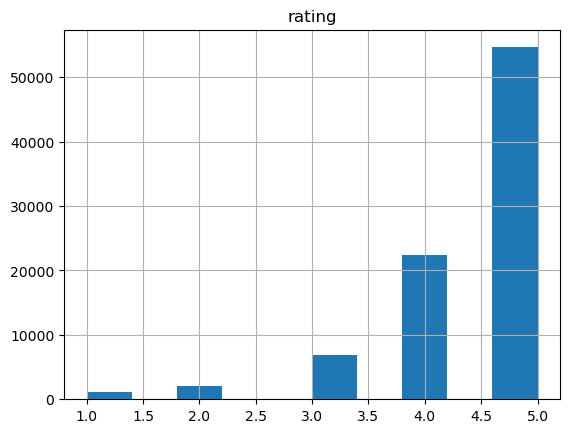

In [114]:
data_master.hist()